# Description

It summarizes the GLS (Generalized Least Squares) results, adjusting pvalues using FDR, and saving the final results to a pickle file for later use.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 3
N_LVS = 987

In [3]:
# Parameters
PHENOPLIER_NOTEBOOK_FILEPATH = (
    "projects/asthma-copd/nbs/30_gls_phenoplier/05-summarize.ipynb"
)

In [4]:
INPUT_DIR = conf.PROJECTS["ASTHMA_COPD"]["RESULTS_DIR"] / "gls_phenoplier" / "gls"
display(INPUT_DIR)
assert INPUT_DIR.exists()

INPUT_PATTERN = "*.tsv.gz"
display(INPUT_PATTERN)

PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gls')

'*.tsv.gz'

In [5]:
PVALUE_COLUMN = "pvalue"

In [6]:
OUTPUT_DIR = conf.PROJECTS["ASTHMA_COPD"]["RESULTS_DIR"] / "gls_phenoplier"
display(OUTPUT_DIR)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier')

# Load data

## Phenotype info

In [7]:
pheno_info = pd.read_csv(conf.PROJECTS["ASTHMA_COPD"]["TRAITS_INFO_FILE"])

In [8]:
pheno_info.shape

(3, 4)

In [9]:
pheno_info.head()

,id,gwas_file,sample_size,n_cases
0,asthma_only,GWAS_Asthma_only_GLM_SNPs_info0.7.txt,181862,19217
1,copd_only,GWAS_COPD_only_GLM_SNPs_info0.7.txt,175700,13055
2,aco,GWAS_ACO_GLM_SNPs_info0.7.txt,169680,7035


In [10]:
assert pheno_info["id"].is_unique

In [11]:
# pheno_code_to_desc_map = pheno_info.set_index("short_code")[
#     "unique_description"
# ].to_dict()

## GLS results

### Get files list

In [12]:
INPUT_FILES = list(INPUT_DIR.glob(INPUT_PATTERN))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gls/GWAS_COPD_only_GLM_SNPs_info0.7-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gls/GWAS_Asthma_only_GLM_SNPs_info0.7-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gls/GWAS_ACO_GLM_SNPs_info0.7-gls_phenoplier.tsv.gz')]

In [13]:
_tmp = len(INPUT_FILES)
display(_tmp)
assert _tmp == N_PHENOTYPES

3

### Read results

In [14]:
INPUT_FILES[0].name.split("gls_phenoplier.")[0]

'GWAS_COPD_only_GLM_SNPs_info0.7-'

In [15]:
dfs = [
    pd.read_csv(
        f, sep="\t", usecols=["lv", "beta", "beta_se", "pvalue_onesided"]
    ).assign(phenotype=f.name.split("gls_phenoplier.")[0])
    for f in INPUT_FILES
]

In [16]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

3

In [17]:
dfs = pd.concat(dfs, axis=0, ignore_index=True).rename(
    columns={"pvalue_onesided": PVALUE_COLUMN}
)

In [18]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(2961, 5)

In [19]:
# # add phenotype description
# dfs = dfs.assign(
#     phenotype_desc=dfs["phenotype"].apply(lambda x: pheno_code_to_desc_map[x])
# )
# dfs = dfs[["phenotype", "phenotype_desc", "lv", "pvalue"]]

In [20]:
dfs.head()

,lv,beta,beta_se,pvalue,phenotype
0,LV247,0.667501,0.126759,7.200244e-08,GWAS_COPD_only_GLM_SNPs_info0.7-
1,LV300,0.620979,0.125634,3.948175e-07,GWAS_COPD_only_GLM_SNPs_info0.7-
2,LV180,0.590544,0.126656,1.592848e-06,GWAS_COPD_only_GLM_SNPs_info0.7-
3,LV696,0.497310,0.125236,3.617882e-05,GWAS_COPD_only_GLM_SNPs_info0.7-
4,LV504,0.478885,0.126907,8.120896e-05,GWAS_COPD_only_GLM_SNPs_info0.7-


In [21]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

### FDR adjust

In [22]:
adj_pval = multipletests(dfs[PVALUE_COLUMN], alpha=0.05, method="fdr_bh")
dfs = dfs.assign(fdr=adj_pval[1])

In [23]:
dfs.shape

(2961, 6)

In [24]:
dfs.head()

,lv,beta,beta_se,pvalue,phenotype,fdr
0,LV247,0.667501,0.126759,7.200244e-08,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000107
1,LV300,0.620979,0.125634,3.948175e-07,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000234
2,LV180,0.590544,0.126656,1.592848e-06,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000619
3,LV696,0.497310,0.125236,3.617882e-05,GWAS_COPD_only_GLM_SNPs_info0.7-,0.008927
4,LV504,0.478885,0.126907,8.120896e-05,GWAS_COPD_only_GLM_SNPs_info0.7-,0.017176


# QQ-plot

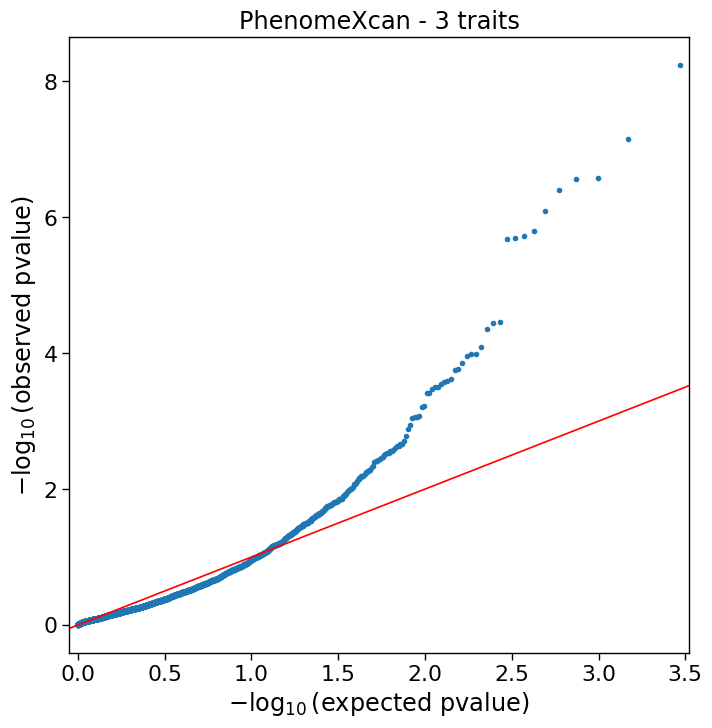

In [25]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(dfs["pvalue"])
    ax.set_title(f"PhenomeXcan - {N_PHENOTYPES} traits")

# Top hits

In [26]:
with pd.option_context("display.max_columns", None, "display.max_colwidth", None):
    _tmp = dfs.sort_values("fdr")  # .drop(columns="phenotype")
    _tmp = _tmp[_tmp["fdr"] < 0.05]
    display(_tmp.head(50))

,lv,beta,beta_se,pvalue,phenotype,fdr
987,LV101,0.725541,0.126975,5.763470e-09,GWAS_Asthma_only_GLM_SNPs_info0.7-,0.000017
0,LV247,0.667501,0.126759,7.200244e-08,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000107
989,LV17,0.651945,0.130076,2.764702e-07,GWAS_Asthma_only_GLM_SNPs_info0.7-,0.000205
988,LV444,0.626413,0.124808,2.666571e-07,GWAS_Asthma_only_GLM_SNPs_info0.7-,0.000205
1,LV300,0.620979,0.125634,3.948175e-07,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000234
1974,LV101,0.617122,0.128485,7.989790e-07,GWAS_ACO_GLM_SNPs_info0.7-,0.000394
2,LV180,0.590544,0.126656,1.592848e-06,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000619
991,LV61,0.580480,0.125812,2.014374e-06,GWAS_Asthma_only_GLM_SNPs_info0.7-,0.000619
990,LV948,0.581716,0.125679,1.876877e-06,GWAS_Asthma_only_GLM_SNPs_info0.7-,0.000619
992,LV705,0.573511,0.124509,2.090083e-06,GWAS_Asthma_only_GLM_SNPs_info0.7-,0.000619


# Optimize data types

In [27]:
dfs.head()

,lv,beta,beta_se,pvalue,phenotype,fdr
0,LV247,0.667501,0.126759,7.200244e-08,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000107
1,LV300,0.620979,0.125634,3.948175e-07,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000234
2,LV180,0.590544,0.126656,1.592848e-06,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000619
3,LV696,0.497310,0.125236,3.617882e-05,GWAS_COPD_only_GLM_SNPs_info0.7-,0.008927
4,LV504,0.478885,0.126907,8.120896e-05,GWAS_COPD_only_GLM_SNPs_info0.7-,0.017176


In [28]:
dfs.dtypes

lv            object
beta         float64
beta_se      float64
pvalue       float64
phenotype     object
fdr          float64
dtype: object

In [29]:
dfs.memory_usage()

Index          128
lv           23688
beta         23688
beta_se      23688
pvalue       23688
phenotype    23688
fdr          23688
dtype: int64

In [30]:
dfs["phenotype"] = dfs["phenotype"].astype("category")
dfs["lv"] = dfs["lv"].astype("category")

In [31]:
dfs.head()

,lv,beta,beta_se,pvalue,phenotype,fdr
0,LV247,0.667501,0.126759,7.200244e-08,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000107
1,LV300,0.620979,0.125634,3.948175e-07,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000234
2,LV180,0.590544,0.126656,1.592848e-06,GWAS_COPD_only_GLM_SNPs_info0.7-,0.000619
3,LV696,0.497310,0.125236,3.617882e-05,GWAS_COPD_only_GLM_SNPs_info0.7-,0.008927
4,LV504,0.478885,0.126907,8.120896e-05,GWAS_COPD_only_GLM_SNPs_info0.7-,0.017176


In [32]:
dfs.memory_usage()

Index          128
lv           46882
beta         23688
beta_se      23688
pvalue       23688
phenotype     3093
fdr          23688
dtype: int64

# Save

## Pickle

In [33]:
output_file = OUTPUT_DIR / "gls-summary.pkl.gz"
display(output_file)

PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gls-summary.pkl.gz')

In [34]:
dfs.to_pickle(output_file)

## Text

In [35]:
output_file = OUTPUT_DIR / "gls-summary.tsv.gz"
display(output_file)

PosixPath('/opt/data/projects/asthma-copd/results/gls_phenoplier/gls-summary.tsv.gz')

In [36]:
dfs.to_csv(output_file, sep="\t", index=False)